In [47]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)

df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)

df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,True,False,False,True,False,True,False,False,True
1,1,True,False,False,True,False,False,True,True,False
2,0,True,False,True,False,True,False,False,False,True
3,1,False,True,True,False,True,False,False,True,False
4,1,False,True,False,True,False,False,True,False,True
5,0,False,True,False,True,False,True,False,False,True
6,0,True,False,False,True,True,False,False,False,True


In [3]:
# What is the entropy S_0 of the initial system?

p_1 = df_train[df_train['Will_go'] == 1].shape[0] / df_train.shape[0]
p_2 = df_train[df_train['Will_go'] == 0].shape[0] / df_train.shape[0]
s_0 = -p_1 * np.log2(p_1) - p_2 * np.log2(p_2)
s_0

0.9852281360342515

In [4]:
# Let’s split the data by the feature “Looks_handsome”. What is the entropy S_1
# of the left group - the one with “Looks_handsome”. What is the entropy S_2
# in the opposite group? What is the information gain (IG) if we consider such a split?

s_1 = -3/4 * np.log2(3/4) - 1/4 * np.log2(1/4)
s_2 = -1/3 * np.log2(1/3) - 2/3 * np.log2(2/3)
IG = s_0 - (4/7 * s_1 + 3/7 * s_2)
s_1, s_2, IG

(0.8112781244591328, 0.9182958340544896, 0.12808527889139443)

[Text(0.4, 0.8333333333333334, 'x[8] <= 0.5\nentropy = 0.985\nsamples = 7\nvalue = [4, 3]'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.6, 0.5, 'x[6] <= 0.5\nentropy = 0.722\nsamples = 5\nvalue = [4, 1]'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]')]

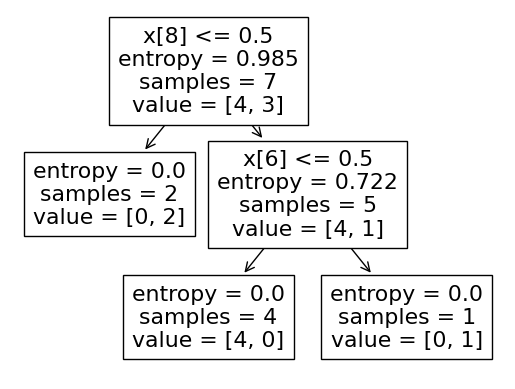

In [5]:
# Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
X_train, y_train = df_train.drop(['Will_go'], axis=1), df_train['Will_go']
clf.fit(X_train, y_train)
plot_tree(clf)

In [6]:
# We have 9 blue balls and 11 yellow balls. Let ball have label 1 if it is blue, 0 otherwise.

balls = [1 for i in range(9)] + [0 for i in range(11)]

# Next split the balls into two groups:

balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

# Implement a function to calculate the Shannon Entropy

def entropy(a_list):
    list_of_numbers_of_repetitions = [a_list.count(i) for i in set(a_list)]
    len_of_a_list = len(a_list)
    entropy_res = 0
    for i in list_of_numbers_of_repetitions:
        entropy_res += -i * np.log2(i/len_of_a_list)/len_of_a_list
    return entropy_res

entropy(balls), entropy(balls_left), entropy(balls_right), entropy([1, 2, 3, 4, 5, 6])

(0.9927744539878083, 0.9612366047228759, 0.5916727785823275, 2.584962500721156)

In [7]:
# 5. What is the information gain from splitting the initial dataset into balls_left and balls_right ?

def information_gain(root, left, right):
    return entropy(root) - (len(left) * entropy(left)/len(root) + len(right) * entropy(right)/len(root))

information_gain(balls, balls_left, balls_right)

0.16088518841412436

In [8]:
# Part 3. The “Adult” dataset

adult_df_train = pd.read_csv('data/adult_train.csv', sep=';')
adult_df_test = pd.read_csv('data/adult_test.csv', sep=';')

# necessary to remove rows with incorrect labels in test dataset
adult_df_test = adult_df_test[
    (adult_df_test["Target"] == " >50K.") | (adult_df_test["Target"] == " <=50K.")
]

# encode target variable as integer
adult_df_train.loc[adult_df_train["Target"] == " <=50K", "Target"] = 0
adult_df_train.loc[adult_df_train["Target"] == " >50K", "Target"] = 1

adult_df_test.loc[adult_df_test["Target"] == " <=50K.", "Target"] = 0
adult_df_test.loc[adult_df_test["Target"] == " >50K.", "Target"] = 1



In [9]:
adult_df_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [10]:
adult_df_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [11]:
adult_df_test["Age"] = adult_df_test["Age"].astype(int)

In [12]:
adult_df_test["fnlwgt"] = adult_df_test["fnlwgt"].astype(int)
adult_df_test["Education_Num"] = adult_df_test["Education_Num"].astype(int)
adult_df_test["Capital_Gain"] = adult_df_test["Capital_Gain"].astype(int)
adult_df_test["Capital_Loss"] = adult_df_test["Capital_Loss"].astype(int)
adult_df_test["Hours_per_week"] = adult_df_test["Hours_per_week"].astype(int)

In [13]:
y_train = adult_df_train.pop('Target')
y_test = adult_df_test.pop('Target')
y_train, y_test = y_train.astype('int'), y_test.astype('int')

In [14]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in adult_df_train.columns if adult_df_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in adult_df_train.columns if adult_df_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [15]:
adult_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [16]:
for c in categorical_columns:
    adult_df_train[c].fillna(adult_df_train[c].mode()[0], inplace=True)
    adult_df_test[c].fillna(adult_df_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    adult_df_train[c].fillna(adult_df_train[c].median(), inplace=True)
    adult_df_test[c].fillna(adult_df_train[c].median(), inplace=True)

In [17]:
adult_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [18]:
adult_df_train = pd.concat(
    [adult_df_train[numerical_columns], pd.get_dummies(adult_df_train[categorical_columns])],
    axis=1,
)

adult_df_test = pd.concat(
    [adult_df_test[numerical_columns], pd.get_dummies(adult_df_test[categorical_columns])],
    axis=1,
)

In [19]:
set(adult_df_train.columns) - set(adult_df_test.columns)

{'Country_ Holand-Netherlands'}

In [20]:
adult_df_test["Country_ Holand-Netherlands"] = 0

In [21]:
set(adult_df_train.columns) - set(adult_df_test.columns)

set()

In [22]:
X_train, X_test = adult_df_train, adult_df_test

In [26]:
# Train a decision tree (DecisionTreeClassifier) with a maximum depth of 3, 
# and evaluate the accuracy metric on the test data. Use parameter random_state = 17 for results reproducibility.

clf = DecisionTreeClassifier(max_depth=3, random_state=17)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test[X_train.columns]))

0.8447884036607088

In [63]:
# Train a decision tree (DecisionTreeClassifier, random_state = 17). 
# Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV).

clf = DecisionTreeClassifier(random_state=17)
parametrs = {"max_depth": range(1, 15)}
search = GridSearchCV(clf, param_grid=parametrs, cv=5)
search.fit(X_train, y_train)
search.best_estimator_

DecisionTreeClassifier(max_depth=9, random_state=17)

In [45]:
best_clf = search.best_estimator_

0.8565770273854106

In [46]:
accuracy_score(y_test, best_clf.predict(X_test[X_train.columns]))

0.8579939807137154

In [64]:
# Train a random forest (RandomForestClassifier). Set the number of trees to 100 and use random_state = 17.

clf = RandomForestClassifier(n_estimators=100, random_state=17)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [49]:
accuracy_score(y_test, clf.predict(X_test[X_train.columns]))

0.8525274860266568

In [59]:
# Train a random forest (RandomForestClassifier). 
# Tune the maximum depth and maximum number of features for each tree using GridSearchCV.

parametrs = {"max_depth": range(10, 16), "max_features": range(5, 105, 20)}
clf = RandomForestClassifier(n_estimators=10, random_state=17)
search = GridSearchCV(clf, param_grid=parametrs, cv=3)
search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=10, random_state=17),
             param_grid={'max_depth': range(10, 16),
                         'max_features': range(5, 105, 20)})

In [62]:
best_clf = search.best_estimator_
accuracy_score(y_test, best_clf.predict(X_test[X_train.columns]))

0.8631533689576807